# Predicción de hospitalizaciones

Una compañía farmacéutica quiere predecir si un paciente será re-hospitalizado en los siguientes 30 días luego del alta médica. Tienen un dataset con información de pacientes, incluyendo:

- Edad

- Diagnóstico principal (categórico)

- Número de días hospitalizado

- Número de visitas previas al hospital

- Glucosa en sangre

- Presión arterial

- Resultado (0: no rehospitalizado, 1: rehospitalizado)

## Objetivo

- Crear un modelo que prediga si un paciente será re-hospitalizado en los siguientes 30 días. 
- Usar ROC AUC, F1 score y recall como métricas de evaluación.
    - Lograr un valor de ROC AUC superior a 0.53
    - Lograr un valor de F1 Score superior a 0.13
    - Lograr un valor de recall superior a 0.087

## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTETomek

from sklearn.inspection import permutation_importance

## Carga del dataset

In [69]:
df = pd.read_csv('hospitalizados.csv')

## Exploración inicial

In [70]:
df.head()

,edad,dias_hospitalizado,visitas_previas,glucosa,presion_arterial,diagnostico,resultado
0,71,9,1,109.393068,113.969478,infeccion,1
1,34,4,1,96.119400,124.185456,cardio,0
2,80,13,1,69.864775,129.270431,cardio,1
3,40,4,0,124.196337,122.115550,diabetes,0
4,43,1,0,89.849242,127.589098,renal,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   edad                300 non-null    int64  
 1   dias_hospitalizado  300 non-null    int64  
 2   visitas_previas     300 non-null    int64  
 3   glucosa             300 non-null    float64
 4   presion_arterial    300 non-null    float64
 5   diagnostico         300 non-null    object 
 6   resultado           300 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 16.5+ KB


In [72]:
df.describe()

,edad,dias_hospitalizado,visitas_previas,glucosa,presion_arterial,resultado
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,53.870000,7.556667,1.023333,111.411418,119.093892,0.316667
std,20.496996,4.094223,0.948219,25.360918,15.806357,0.465953
min,20.000000,1.000000,0.000000,48.621874,69.173579,0.000000
25%,37.000000,4.000000,0.000000,95.219837,109.220112,0.000000
50%,53.500000,7.000000,1.000000,111.135941,119.999305,0.000000
75%,72.000000,11.000000,2.000000,127.898248,130.175230,1.000000
max,89.000000,14.000000,4.000000,187.351225,167.129505,1.000000


<span style=color:orange> Comentario <span/>

- No hay valores ausentes.
- Los tipos de datos son adecuados. 
- Las variables días hospitalizado y visitas previas son variables numéricas discretas.

### Exploración de datos duplicados

In [73]:
print('Valores duplicados totales:', df.duplicated().sum())

Valores duplicados totales: 0


### Exploración de valores únicos en columna diagnóstico

In [74]:
df['diagnostico'].value_counts()

diagnostico
infeccion    81
diabetes     78
renal        71
cardio       70
Name: count, dtype: int64

<span style=color:orange> Comentario <span/>

- No hay valores duplicados totales.
- Hay 4 valores únicos en la característica de diagnóstico.

### Exploración de distribución de variables numéricas

C:\Users\lbtoj\AppData\Local\Temp\ipykernel_10732\569595816.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=plt.gca())


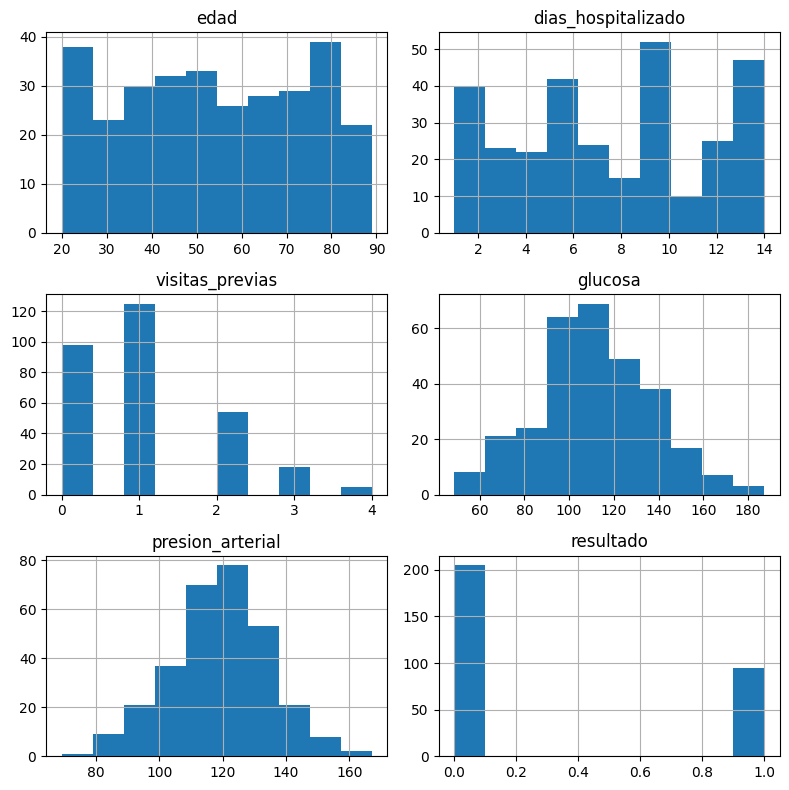

In [75]:
plt.figure(figsize=(8,8))
df.hist(ax=plt.gca())
plt.tight_layout()
plt.show()

<span style=color:orange> Comentario <span/>

- Solo las variables de glucosa y presión arterial siguen una distribución normal.
- Hay un claro desbalance de clases entre los resultados 0 y 1.

### Exploración de valores atípicos

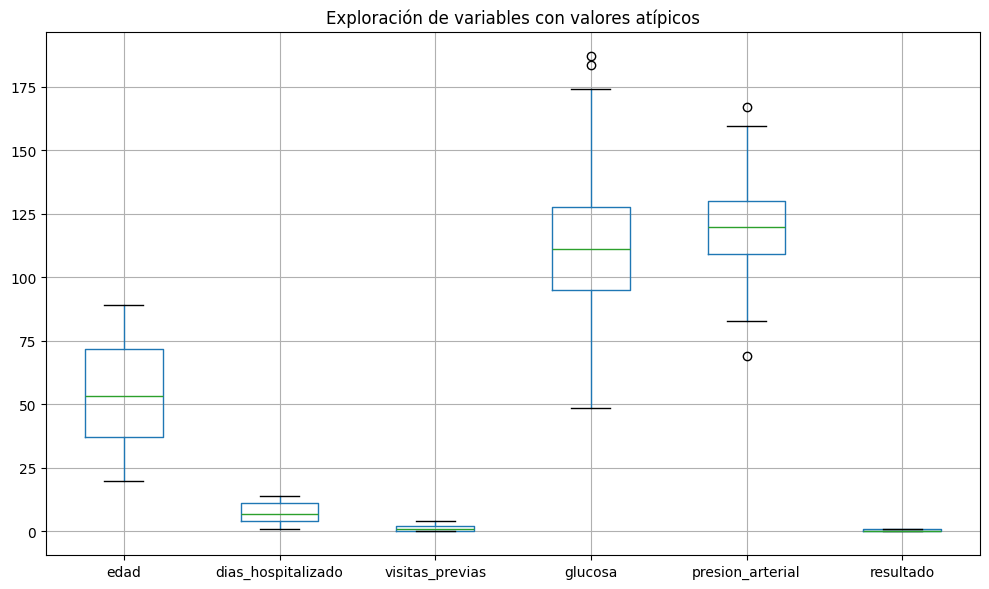

In [76]:
# Exloración rápida para encontrar las columnas con presencia de valores atípicos

plt.figure(figsize=(10,6))
df.boxplot()
plt.title('Exploración de variables con valores atípicos')
plt.tight_layout()
plt.show()

<span style=color:orange> Comentario <span/>

- Solo las variables glucosa y presión arterial tienen valores atípicos

#### Exploración de valores atípicos en columnas identificadas

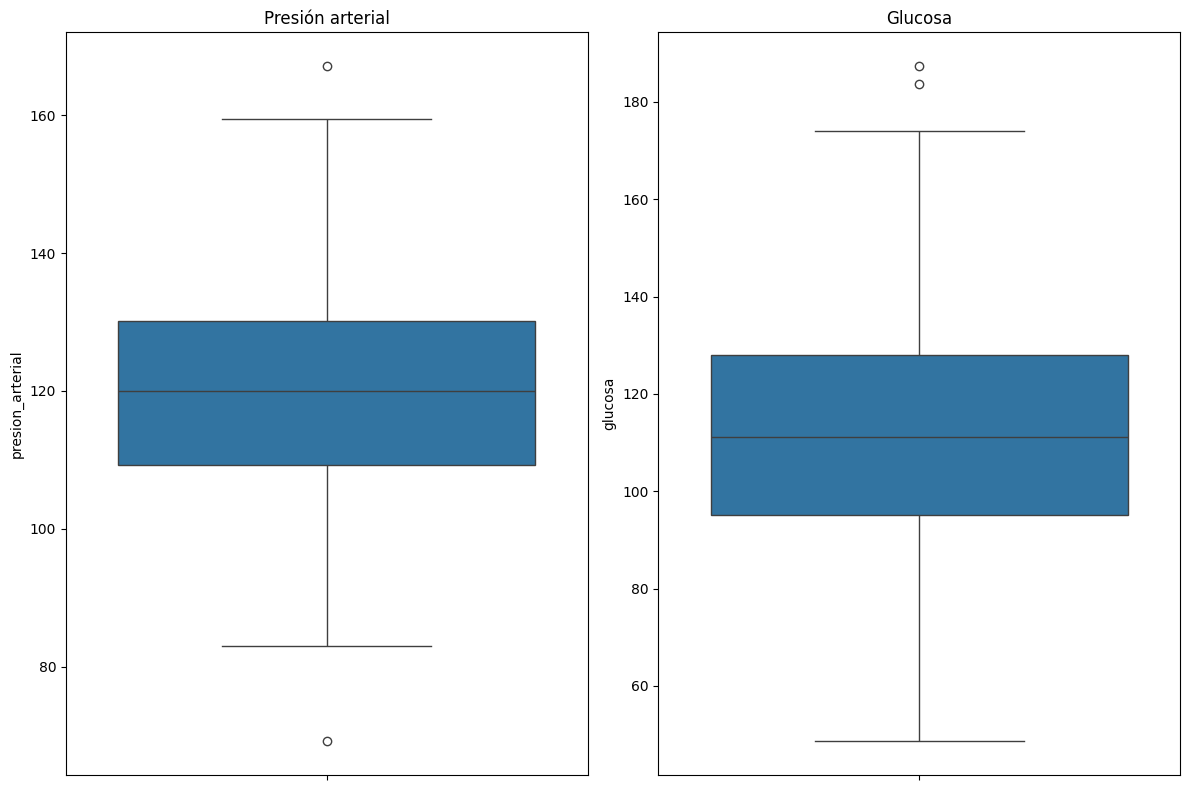

In [77]:
# Cuadrícula 1 x 2
fig, axs = plt.subplots(1, 2, figsize=(12,8))

# Presión arterial
sns.boxplot(df['presion_arterial'], ax=axs[0])
# Glucosa
sns.boxplot(df['glucosa'], ax=axs[1])

# Títulos
axs[0].set_title('Presión arterial')
axs[1].set_title('Glucosa')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()


<span style=color:orange> Comentario <span/>

- En la variable presión arterial, los valores atípicos se presentan por debajo de 80 y por arriba de 160.
- En la variable glucosa, los valores atípicos se presentan solo por arriba de 180.

### <span style=color:orange> Comentario final de exploración inicial <span/>

- No se requieren acciones para tratamiento de datos ausentes ni duplicados.
- Se requiere eliminar los valores atípicos en las variables glucosa y presión arterial.
- Se entrenarán modelos de clasificación basados en árboles, por lo que no será necesaria el ajuste en la distribución de las variables numéricas. 
- Se requiere balance de clases.
- La variable categórica diagnostico solo tiene 4 valores únicos, por lo que no hay riesgo de cardinalidad al realizar la codificación.
- La variable numerica visitas_previas tiene pocos valores unicos (0 a 4), por lo que la trataré como categórica. 
- La variable días previos es numérica discreta, la consideraré como categórica para aumentar las características buscando mejorar la predicción.

## Ingeniería de características

### Elminación de valores atípicos

In [78]:
# Eliminación de valores por debajo de 80 o por arriba de 160 en presión arterial o por arriba de 180 en glucosa
df_no_outilers = df.query('glucosa < 180 and 80 < presion_arterial < 160')

Text(0.5, 1.0, 'Visualización de valores atípicos')

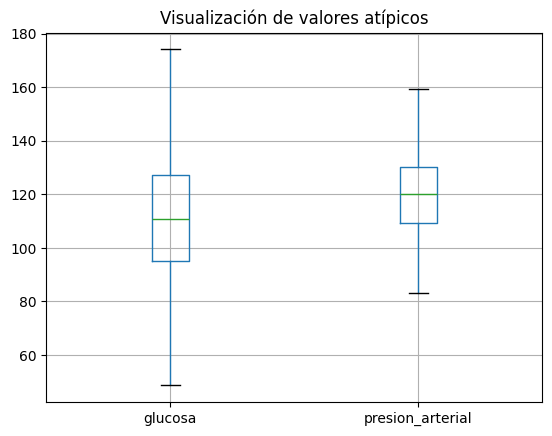

In [79]:
# Visualización de valores atípicos en columnas objetivo
df_no_outilers[['glucosa', 'presion_arterial']].boxplot()
plt.title('Visualización de valores atípicos')

<span style=color:orange> Comentario <span/>

- Se eliminaron correctamente los valores atípicos.

### Ingeniería en conjuntos de prueba y entrenamiento

In [80]:
# Separación de características y objetivo
X = df_no_outilers.drop('resultado', axis=1)
y = df_no_outilers['resultado']

In [81]:
# Creación de conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1993)

#### Codificación de características categóricas

In [82]:
# Tamaño de sets de entrenamiento y prueba
print('X_train:', X_train.shape, '\n', 'X_test:', X_test. shape)

X_train: (222, 6) 
 X_test: (74, 6)


In [83]:
# Conversión de variable visitas_previas a object
X_train['visitas_previas'] = X_train['visitas_previas'].astype(object)
X_test['visitas_previas'] = X_test['visitas_previas'].astype(object)

# Conversión de variable dias_hospitalizado a object
X_train['dias_hospitalizado'] = X_train['dias_hospitalizado'].astype(object)
X_test['dias_hospitalizado'] = X_test['dias_hospitalizado'].astype(object)

In [84]:
# Selección de columnas categoricas
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [85]:
# Creacion del codificador OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajuste del codificador solo al conjunto de entrenamiento
encoder.fit(X_train[categorical_cols])

OneHotEncoder(drop='first', sparse_output=False)

In [86]:
# Transformación de ambos conjuntos
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

In [87]:
# Obtener nombres de características codificadas
encoded_feature_names = encoder.get_feature_names_out(
    input_features=categorical_cols)

In [88]:
# Creación de dataframe con los nuevos nombres de columnas codificadas y restauración de índices
X_train_encoded = pd.DataFrame(np.array(
    X_train_encoded), columns=encoded_feature_names, index=X_train.index)
X_test_encoded = pd.DataFrame(np.array(
    X_test_encoded), columns=encoded_feature_names, index=X_test.index)

In [89]:
# Eliminación de las columnas categoricas originales de los dataframes.
X_train_numerical = X_train.drop(categorical_cols, axis=1)
X_test_numerical = X_test.drop(categorical_cols, axis=1)

# Concatenar los dataframes codificados con los dataframes numericos.
X_train = pd.concat([X_train_numerical, X_train_encoded], axis=1)
X_test = pd.concat([X_test_numerical, X_test_encoded], axis=1)

In [90]:
# Tamaño de sets de entrenamiento y prueba después de OHE
print('X_train:', X_train.shape, '\n', 'X_test:', X_test. shape)

X_train: (222, 23) 
 X_test: (74, 23)


<span style=color:orange> Comentario <span/>

- Después de la codificación OHE los conjuntos de entrenamiento y prueba pasaron de 6 características a 23.

#### Balance de clases

Text(0.5, 1.0, 'Balance de clases')

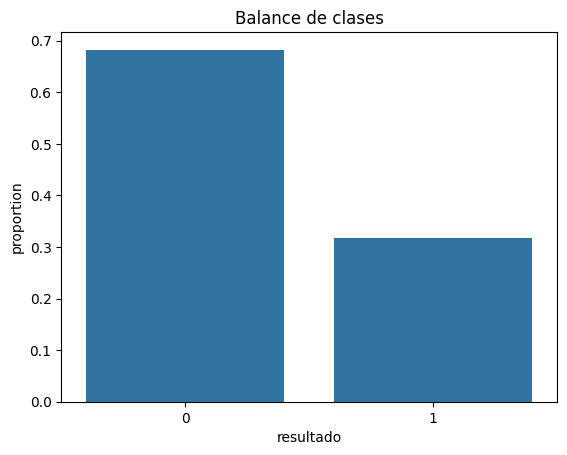

In [91]:
# Exploración de balance de clases en resultado

sns.barplot(y.value_counts(normalize=True))
plt.title('Balance de clases')

<span style=color:orange> Comentario <span/>

- La distribución de las clases es aproximadamente 2:1 clases negativas a positivas.
- Se utilizará la técnica de remuestreo SMOTE para equilibrar las clases.

##### Aplicación de SMOTE para balance de clases

In [92]:
# Ajuste de SMOTE para remuestreo
smote = SMOTETomek(random_state=1993)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

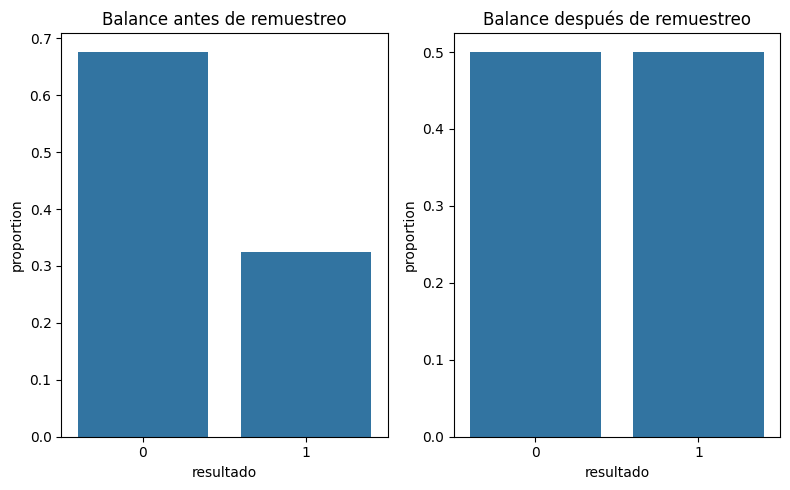

In [93]:
# Visualización de balanceo
# Cuadrícula 1 x 2 
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Antes de remuestreo
sns.barplot(y_train.value_counts(normalize=True), ax=axs[0])

# Después del remuestreo
sns.barplot(y_train_resampled.value_counts(normalize=True), ax=axs[1])

# Títulos
axs[0].set_title('Balance antes de remuestreo')
axs[1].set_title('Balance después de remuestreo')

# Ajuste al tamaño
plt.tight_layout()

# Mostrar figuras
plt.show()

<span style=color:orange> Comentario <span/>

- El remuestreo fue efectivo, las clases ahoran están balanceadas 50:50.

#### Estandarización de características numéricas

In [94]:
# Se utilizará codificador StandardScaler
scaler = StandardScaler()

In [95]:
# Escalamiento de características numéricas en conjunto de entrenamiento
scaler.fit(X_train_resampled.iloc[:, :3])

StandardScaler()

In [96]:
# Aplicación del escalador en conjunto de entrenamiento y prueba
X_train_scaled = scaler.transform(X_train_resampled.iloc[:, :3])
X_test_scaled = scaler.transform(X_test.iloc[:, :3])

In [97]:
# Convertir datos escalados a DataFrame
# Datos escalados de entrenamiento
X_train_scaled = pd.DataFrame(
    X_train_scaled, index=X_train_resampled.index, columns = X_train_resampled.iloc[:, :3].columns)

In [98]:
# Datos escalados de prueba
X_test_scaled = pd.DataFrame(
    X_test_scaled, index = X_test.index, columns = X_test.iloc[:, :3].columns
)

In [99]:
# Unión de características numéricas escaladas con categóricas 
# Conjunto de entrenamiento
X_train_ready = pd.concat([X_train_scaled, X_train_resampled.iloc[:, 3:]], axis=1)

# Conjunto de prueba
X_test_ready = pd.concat([X_test_scaled, X_test.iloc[:, 3:]], axis=1)

In [120]:
# Efectividad de escalamiento: verificación de medias y desviación estándar de valores estandarizados
# Conjunto de entrenamiento
display(X_train_scaled.describe())

# Conjunto de prueba
X_test_scaled.describe()

,edad,glucosa,presion_arterial
count,2.600000e+02,2.600000e+02,2.600000e+02
mean,3.074464e-17,-2.527892e-16,6.148928e-16
std,1.001929e+00,1.001929e+00,1.001929e+00
min,-1.715889e+00,-2.453741e+00,-2.493373e+00
25%,-7.981334e-01,-5.953812e-01,-7.184074e-01
50%,-8.432368e-02,-2.211679e-02,1.103061e-01
75%,8.844181e-01,6.052415e-01,7.347116e-01
max,1.802174e+00,2.391722e+00,2.727305e+00


,edad,glucosa,presion_arterial
count,74.000000,74.000000,74.000000
mean,-0.053318,-0.075234,-0.069105
std,1.089354,1.097672,1.099825
min,-1.715889,-2.588418,-2.394198
25%,-0.989332,-0.778047,-0.866839
50%,-0.084324,-0.016562,-0.122771
75%,0.871672,0.678924,0.542351
max,1.802174,2.593562,2.561057


### <span style=color:orange> Comentario final de ingeniería de características <span/>

- Se aplicó SMOTE Tomek para el balanceo de clases, logrando una proporcion 50:50 en las clases negativas y positivas.
- Se aplicaron codificación OHE para la característica categórica diagnostico y visitas previas
- Se aplicó estandarización de variable numéricas con StandarScaler, confirmando la efectividad de la transformación al calcular las medias (cercanas a 0) y desviaciones estandar (cercanas a 1).

## Modelos predictivos

### Regresión logística

In [102]:
# Creación del modelo
log_reg = LogisticRegression()

# Ajuste del modelo
log_reg.fit(X_train_ready, y_train_resampled)

# Probabilidades de predicción del modelo
y_pred_proba_log = log_reg.predict_proba(X_test_ready)[:, 1]

# Predicciones del modelo
y_pred_log = log_reg.predict(X_test_ready)

# Evaluar rendimiento del modelo 
accuracy_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
roc_auc_log = roc_auc_score(y_test, y_pred_proba_log)

print(f'Accuracy score modelo regresión: {accuracy_log:.2f}')
print(f'F1 score modelo regresión: {f1_log:.2f}')
print(f'Recall modelo regresión: {recall_log:.2f}')
print(f'ROC_AUC modelo regresión: {roc_auc_log:.2f}')

Accuracy score modelo regresión: 0.53
F1 score modelo regresión: 0.36
Recall modelo regresión: 0.45
ROC_AUC modelo regresión: 0.54


### Bosque aleatorio

In [103]:
# Hiperparametros a probar
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 15]
}

# Configuración de la validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [104]:
# Creación del modelo de bosque aleatorio
# Se usa gridsearch con validación cruzada para optimizar hiperparámetros
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_ready, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy')

In [105]:
# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score accuracy: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'max_depth': 10, 'n_estimators': 500}
Mejor score accuracy: 0.74


In [ ]:
# Mejor modelo
best_rf_clf = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
# Probabilidades para la clase positiva
y_pred_proba = best_rf_clf.predict_proba(X_test_ready)[:, 1]
y_pred = best_rf_clf.predict(X_test_ready)  # Predicciones de clase

# Calcular F1 score, recall y ROC AUC en el conjunto de prueba
f1_rf = f1_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba)

# Imprimir resultados en el conjunto de prueba
print(f'F1 score modelo random forest: {f1_rf:.2f}')
print(f'Recall modelo random forest: {recall_rf:.2f}')
print(f'ROC_AUC modelo random forest: {roc_auc_rf:.2f}')

F1 score modelo random forest: 0.35
Recall modelo random forest: 0.32
ROC_AUC modelo random forest: 0.52


### Árbol de decisión

In [107]:
# Hiperparametros a probar
param_grid = {
    'max_depth': [10, 15, 20]
}

# Configuración de la validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [108]:
# Creación del modelo de bosque aleatorio
# Se usa gridsearch con validación cruzada para optimizar hiperparámetros
dt_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_ready, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20]}, scoring='accuracy')

In [109]:
# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score accuracy: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'max_depth': 15}
Mejor score accuracy: 0.65


In [ ]:
# Mejor modelo
best_dt_clf = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
# Probabilidades para la clase positiva
y_pred_proba = best_dt_clf.predict_proba(X_test_ready)[:, 1]
y_pred = best_dt_clf.predict(X_test_ready)  # Predicciones de clase

# Calcular F1 score, recall y ROC AUC en el conjunto de prueba
f1_dt = f1_score(y_test, y_pred)
recall_dt = recall_score(y_test, y_pred)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba)

# Imprimir resultados en el conjunto de prueba
print(f'F1 score modelo tree: {f1_dt:.2f}')
print(f'Recall modelo tree: {recall_dt:.2f}')
print(f'ROC_AUC modelo tree: {roc_auc_dt:.2f}')

F1 score modelo random forest: 0.32
Recall modelo random forest: 0.41
ROC_AUC modelo random forest: 0.46


### Light GBM

In [111]:
# Definir la cuadrícula de parámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 15],
    'reg_alpha': [0.3, 0.5, 0.7],
    'reg_lambda': [0.3, 0.5, 0.7]
}

# Configuración de la validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [112]:
# Crear el modelo LightGBM
lgbm_model = lgb.LGBMClassifier(
    objective='binary', random_state=42, verbose=-1)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(lgbm_model, param_grid, cv=cv, scoring='accuracy')

# Realizar la búsqueda
grid_search.fit(X_train_ready, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(objective='binary', random_state=42,
                                      verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 15],
                         'n_estimators': [100, 500, 1000],
                         'reg_alpha': [0.3, 0.5, 0.7],
                         'reg_lambda': [0.3, 0.5, 0.7]},
             scoring='accuracy')

In [113]:
# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score accuracy: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 0.7, 'reg_lambda': 0.3}
Mejor score accuracy: 0.71


In [ ]:
# Mejor modelo
best_lgbm = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
# Probabilidades para la clase positiva
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test_ready)[:, 1]
y_pred_lgbm = best_lgbm.predict(X_test_ready)  # Predicciones de clase

# Calcular F1 score, recall y ROC AUC en el conjunto de prueba
f1_lgbm = f1_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

# Imprimir resultados en el conjunto de prueba
print(f'F1 score modelo GBM: {f1_lgbm:.2f}')
print(f'Recall modelo GBM: {recall_lgbm:.2f}')
print(f'ROC_AUC modelo GBM: {roc_auc_lgbm:.2f}')

F1 score modelo random forest: 0.41
Recall modelo random forest: 0.36
ROC_AUC modelo random forest: 0.57


<span style=color:orange> Comentario <span/>

- El modelo con la mejor combinación de métricas corresponde al Light GBM.
- Se usaran los resultados de predicción y probabilidad para ajustar el umbral de clasificación, buscando aumentar el recall y el F1 así como para la visualización de características más relevantes.

## Ajuste de umbral de clasificación

In [118]:
# Calculo de curva ROC
fpr, tpr, umbral = roc_curve(y_test, y_pred_proba_lgbm)

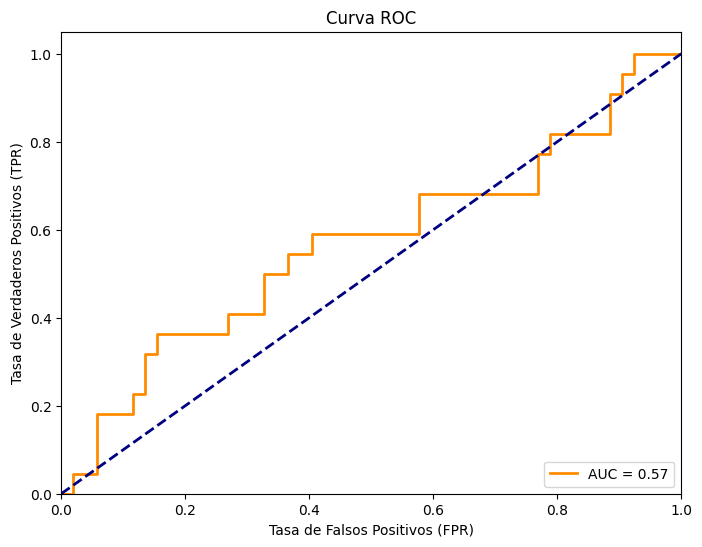

In [119]:
# Gráfica de curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_lgbm:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [135]:
# Umbral optimo
desired_tpr = 0.75
indice_umbral = (np.abs(tpr - desired_tpr)).argmin()

umbral_optimo = umbral[indice_umbral]
umbral_optimo

0.17196912138941847

In [ ]:
# Aplicación de nuevo umbral
y_pred_con_umbral = np.where(y_pred_proba_lgbm >= umbral_optimo, 1, 0)

print("\nReporte de Clasificación con el umbral:", umbral_optimo)
print(classification_report(y_test, y_pred_con_umbral))


Reporte de Clasificación con el umbral: 0.17196912138941847
              precision    recall  f1-score   support

           0       0.71      0.23      0.35        52
           1       0.30      0.77      0.43        22

    accuracy                           0.39        74
   macro avg       0.50      0.50      0.39        74
weighted avg       0.58      0.39      0.37        74



## Visualización de importancia de las características

In [139]:
# Importancia de la permutación
result = permutation_importance(
    best_lgbm, X_test_ready, y_test, n_repeats=10, random_state=42)

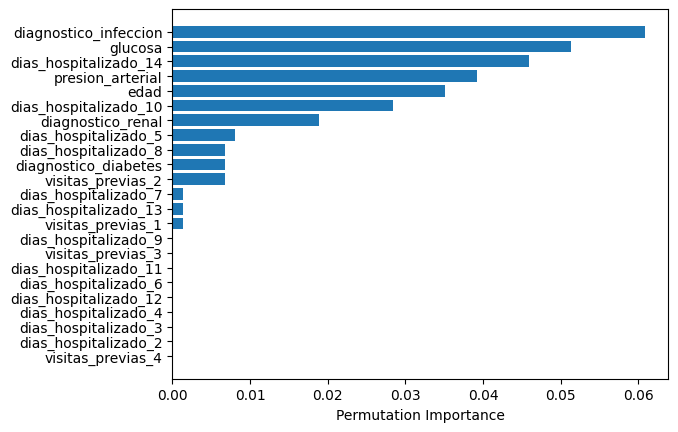

In [140]:
# Visualizar la importancia de las características
sorted_idx = result.importances_mean.argsort()
plt.barh(X_test_ready.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

# <span style=color:orange> Conclusiones del proyecto <span/>

- Se cumple el objetivo del proyecto al superar las métricas establecidas:
    - ROC AUC de 0.57
    - F1 score de 0.43
    - Recall de 0.77
- El mejor modelo corresponde al Ligh GBM con hiperparámetros ajustados.
- Para elevar las métricas del modelo se requirió de aumentar las variables a través de la ingeniería de características, tratando dos variables numéricas discretas como categóricas. 
- Se priorizó elevar el recall con el ajuste del umbral de clasificación, derivado de la importancia de no omitir un posible reingreso hospitalario, es mejor un falso positivo que un falso negativo en este contexto.
- Las características más relevantes para la rehospitalización fueron:
     1. diagnóstico de infección
     2. nivel de glucosa en sangre
     3. hospitalización previa de 14 días
     4. nivel de presión arterial 
     5. edad
     6. hospitalización previa de 10 días
     7. diagnóstico renal